#VGG19

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU


data_dir = '/content/drive/MyDrive/Colab Notebooks/Tesis/aves_galapagos'

classes = os.listdir(data_dir)

def verify_directories(data_dir, classes):
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            raise FileNotFoundError(f"Directorio no encontrado: {class_dir}")

verify_directories(data_dir, classes)

all_images = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)
    for image in images:
        all_images.append((os.path.join(class_dir, image), class_name))
random.shuffle(all_images)


x_data, y_data = zip(*all_images)


image_size = (224, 224)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111, random_state=42)

data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

def create_data_generator(dataframe, target_size, batch_size, shuffle=True, seed=42):
    return data_generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='class_name',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
        seed=seed,
        classes=classes
    )

train_df = pd.DataFrame({'image_path': x_train, 'class_name': y_train})
val_df = pd.DataFrame({'image_path': x_val, 'class_name': y_val})
test_df = pd.DataFrame({'image_path': x_test, 'class_name': y_test})

train_data = create_data_generator(train_df, image_size, batch_size=32)
val_data = create_data_generator(val_df, image_size, batch_size=32)
test_data = create_data_generator(test_df, image_size, batch_size=32, shuffle=False)

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers[:-4]:
    layer.trainable = False

model = Sequential()

model.add(vgg_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation=LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(256, activation=LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))


model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

history = model.fit(train_data, epochs=30, validation_data=val_data, callbacks=[early_stopping])

execution_time = time.time() - start_time

test_loss, test_accuracy = model.evaluate(test_data)

y_pred_prob = model.predict(test_data)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

print(f"Time in: {execution_time:.2f} seconds")

Found 5830 validated image filenames belonging to 58 classes.
Found 728 validated image filenames belonging to 58 classes.
Found 729 validated image filenames belonging to 58 classes.
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/30
183/183 [==============================] - 1258s 7s/step - loss: 3.7282 - accuracy: 0.1286 - val_loss: 3.4721 - val_accuracy: 0.1607
Epoch 2/30
183/183 [==============================] - 117s 640ms/step - loss: 3.2151 - accuracy: 0.1840 - val_loss: 2.8359 - val_accuracy: 0.2500
Epoch 3/30
183/183 [==============================] - 118s 647ms/step - loss: 2.5466 - accuracy: 0.2986 - val_loss: 2.2472 - val_accuracy: 0.3585
Epoch 4/30
183/183 [==============================] - 117s 637ms/step - loss: 2.0923 - accuracy: 0.4005 - val_loss: 1.9001 - val_accuracy: 0.4533
Epoch 5/30
183/183 [==============================] - 117s 639ms/step - loss: 1.7783 - accuracy: 0.4919 - val_loss: 1.7446 - val_accuracy: 0.4986
Epoch 6/30
183/183 [===

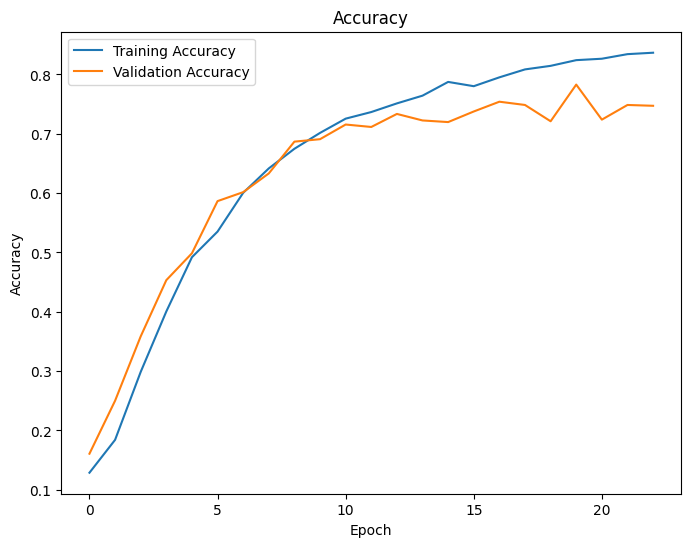

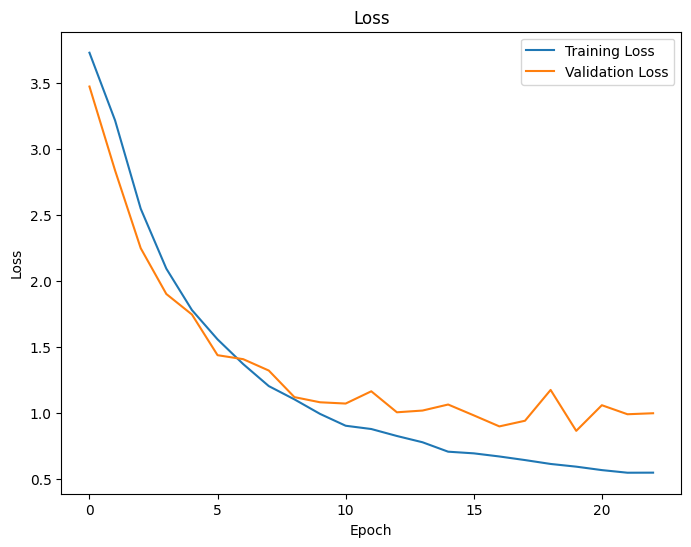

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
